In [145]:
%load_ext autoreload
%autoreload 2
from imports import *
from simcodes.helpers import *
%run simcodes/MultiBandSim.py

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
cluster.close()

In [ ]:
cluster = SSHCluster(
                ["dodo1","dodo1",'dodo2','dodo3','dodo4']+["dodo5","dodo6"],
    worker_options={"nthreads": 100},
                connect_options={"known_hosts": None,"username": "ktisanic"},
                scheduler_options={"port": 0, "dashboard_address": ":46065"}
            )


In [7]:

stars = pd.read_csv('data/query_1610017978.44685i.txt',skiprows=6,sep='\t')
stars['field']=stars['# ID'].str.split('-').apply(lambda x:x[1])
stars['Iband']=stars['# ID'].apply(lambda x:'data/ogle/I/'+x+'.dat')
stars['Vband']=stars['# ID'].apply(lambda x:'data/ogle/V/'+x+'.dat')

stars = pd.read_csv('data/query_1610017978.44685i.txt',skiprows=6,sep='\t')
stars['field']=stars['# ID'].str.split('-').apply(lambda x:x[1])
stars['Iband']=stars['# ID'].apply(lambda x:'data/ogle/I/'+x+'.dat')
stars['Vband']=stars['# ID'].apply(lambda x:'data/ogle/V/'+x+'.dat')
stars = stars[stars['field']=='BLG']

In [ ]:

Analysis = pd.DataFrame()
Nreps = 60#
Percents = [30,50]

stats = ['mean','median','std','sem',p16,p84,med_sig,unexplained_variance,Outliers1,Outliers3]
Stats = ['mean','median','std','sem','p16','p84','med_sig','unexplained_variance', 'Outliers1','Outliers3']
Widths = np.round(np.logspace(-3,np.log10(0.4),5),3)
for w in Widths:
        try:
            os.mkdir(f'outputs/windows/w_{w}/')
        except:
            pass
for i in stars.index[:100]:
        with open('Bootstrap_log.txt','w') as log:
                print(i, stars.loc[i,'# ID'],end='\t',file=log)
                print(i, stars.loc[i,'# ID'],end='\t')
                inds = []
                try:
                    Iband = pd.read_csv(stars.loc[i,'Iband'],names=['t','mag','magerr'],sep=' ')
                    Iband['filt'] = 'I'
                    inds.append(0)
                except:
                    print('No I',end='\t')
                    print('No I',end='\t',file=log)
                    Iband = None
                try:
                    Vband = pd.read_csv(stars.loc[i,'Vband'],names=['t','mag','magerr'],sep=' ')
                    Vband['filt']= 'V'
                    inds.append(1)
                except:
                    print('No V', end='\t')
                    print('No V', end='\t',file=log)
                    Vband=None
                if len(inds)==2:
                    D=pd.concat([Iband,Vband])
                elif len(inds)==1:
                    D = [Iband,Vband][inds[0]]
                else:
                    continue
                file = 'data/ogle/sources/'+stars.loc[i,'# ID']+'.dat'
                D.to_csv(file)
                N_I = (D['filt']=='I').count()
                N_V = (D['filt']=='V').count()
                Nmax = N_I+ N_V
                Sim = MCSimulation('data/ogle/sources/', stars.loc[i,'P_1'], file,verbose=False)
                Sim.compute_phase()

                #sims=np.unique(np.round(Nmax*Percents).astype(int))


                
                #for Per in Percents:
                ok = False


                for _ in range(3):
                        Sim.produce_bootstrap(Percents,Nreps)
                    
                        Sim.remove_window_variable_width(np.array([Widths.size*[0.5],Widths]).T)
                        print(f"Bootstrap {_}",end='\t',file=log)
                        print(f"Bootstrap {_}", end='\t')
                        #Sim.produce_bootstrap([Per],Nreps)
                        try:
                            Sim.run_simulation('fast',cluster=cluster)
                            Sim.Simulated_periods.loc[:,'w'] = np.tile(Widths, np.sort(np.tile(Percents,Nreps)).size)
                            ok = True
                        except:
                            print(Percents,'Fail',end='\t')
                            print(Percents,'Fail',end='\t',file=log)
                        
                        
                        if ok:
                            
                            for w in Widths:
                                
                                _Sim = Sim.Simulated_periods.loc[Sim.Simulated_periods['w']==w,:]
                                _Sim.loc[:,'N'] = _Sim['N'].astype(float)/len(inds)
                                _Sim.loc[:,'Nbin'] = pd.cut(_Sim['N'],[10,20,30,50,np.inf])
                                Stat = _Sim.groupby('Nbin').agg({'P':stats,'N':'mean'})
                                
                                for ind in Stat.index:
                                    Dict = {'Name':stars.loc[i,'# ID'],'OGLE period':stars.loc[i,'P_1'],#'LS period':Sim.best_fitting[1],
                                        'N_I':N_I,'N_V':N_V}
                                    for st in Stats:
                                        Dict[st] = Stat.loc[ind,('P',st)]
                                    Dict['window'] = w
                                    Dict['Nobs'] = ind
                                    Dict['mean N'] = Stat.loc[ind,('N','mean')]
                                    Analysis = Analysis.append(Dict, ignore_index=True)
                                    Analysis.to_csv('Manystars.csv')
                            print(ok)
                            print(ok,file=log)
                                        
                            break
                
cluster.close()

27381 OGLE-BLG-RRLYR-00001	Bootstrap 0	D	

/home/ktisanic/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/ktisanic/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)


True
27382 OGLE-BLG-RRLYR-00002	Bootstrap 0	D	True
27383 OGLE-BLG-RRLYR-00003	Bootstrap 0	D	True
27384 OGLE-BLG-RRLYR-00004	Bootstrap 0	D	True
27385 OGLE-BLG-RRLYR-00005	Bootstrap 0	D	True
27386 OGLE-BLG-RRLYR-00006	Bootstrap 0	D	True
27387 OGLE-BLG-RRLYR-00007	Bootstrap 0	D	True
27388 OGLE-BLG-RRLYR-00008	Bootstrap 0	D	True
27389 OGLE-BLG-RRLYR-00009	Bootstrap 0	

In [ ]:

Analysis = pd.DataFrame()
Nreps = 8#
Percents = [7,10,15,70]

stats = ['mean','median','std','sem',p16,p84,med_sig,unexplained_variance,Outliers1,Outliers3]
Stats = ['mean','median','std','sem','p16','p84','med_sig','unexplained_variance', 'Outliers1','Outliers3']
Widths = np.round(np.logspace(-3,np.log10(0.4),10),3)
for w in Widths:
        try:
            os.mkdir(f'outputs/windows/w_{w}/')
        except:
            pass
for i in stars.index[:5]:
    for w in Widths:
        with open('Bootstrap_log.txt','w') as log:
                print(i, stars.loc[i,'# ID'],end='\t',file=log)
                print(i, stars.loc[i,'# ID'],end='\t')
                inds = []
                try:
                    Iband = pd.read_csv(stars.loc[i,'Iband'],names=['t','mag','magerr'],sep=' ')
                    Iband['filt'] = 'I'
                    inds.append(0)
                except:
                    print('No I',end='\t')
                    print('No I',end='\t',file=log)
                    Iband = None
                try:
                    Vband = pd.read_csv(stars.loc[i,'Vband'],names=['t','mag','magerr'],sep=' ')
                    Vband['filt']= 'V'
                    inds.append(1)
                except:
                    print('No V', end='\t')
                    print('No V', end='\t',file=log)
                    Vband=None
                if len(inds)==2:
                    D=pd.concat([Iband,Vband])
                elif len(inds)==1:
                    D = [Iband,Vband][inds[0]]
                else:
                    continue
                file = 'data/ogle/sources/'+stars.loc[i,'# ID']+'.dat'
                D.to_csv(file)
                N_I = (D['filt']=='I').count()
                N_V = (D['filt']=='V').count()
                Nmax = N_I+ N_V
                Sim = MCSimulation('data/ogle/sources/', stars.loc[i,'P_1'], file,verbose=False)
                Sim.compute_phase()

                #sims=np.unique(np.round(Nmax*Percents).astype(int))


                Dict = {'Name':stars.loc[i,'# ID'],'OGLE period':stars.loc[i,'P_1'],#'LS period':Sim.best_fitting[1],
                        'N_I':N_I,'N_V':N_V}
                #for Per in Percents:
                ok = False


                for _ in range(3):
                        Sim.produce_bootstrap(Percents,Nreps)
                        Sim.remove_window(0.5,w)
                        print(f"Bootstrap {_}",f"window {w}", end='\t',file=log)
                        print(f"Bootstrap {_}",f"window {w}", end='\t')
                        #Sim.produce_bootstrap([Per],Nreps)
                        try:
                            Sim.run_simulation('fast',cluster=cluster)
                            ok = True
                        except:
                            print(Percents,'Fail',end='\t')
                            print(Percents,'Fail',end='\t',file=log)
                        if ok:
                            Stat = Sim.Simulated_periods.groupby('N').agg({'P':stats})
                            for ind in Stat.index:
                                for st in Stats:
                                    Dict[f'{ind} '+st] = Stat.loc[ind,('P',st)]
                                    Dict['window'] = w
                            break
                print(ok)
                print(ok,file=log)
                Analysis = Analysis.append(Dict, ignore_index=True)
                Analysis.to_csv('Manystars.csv')
#cluster.close()

/home/ktisanic/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


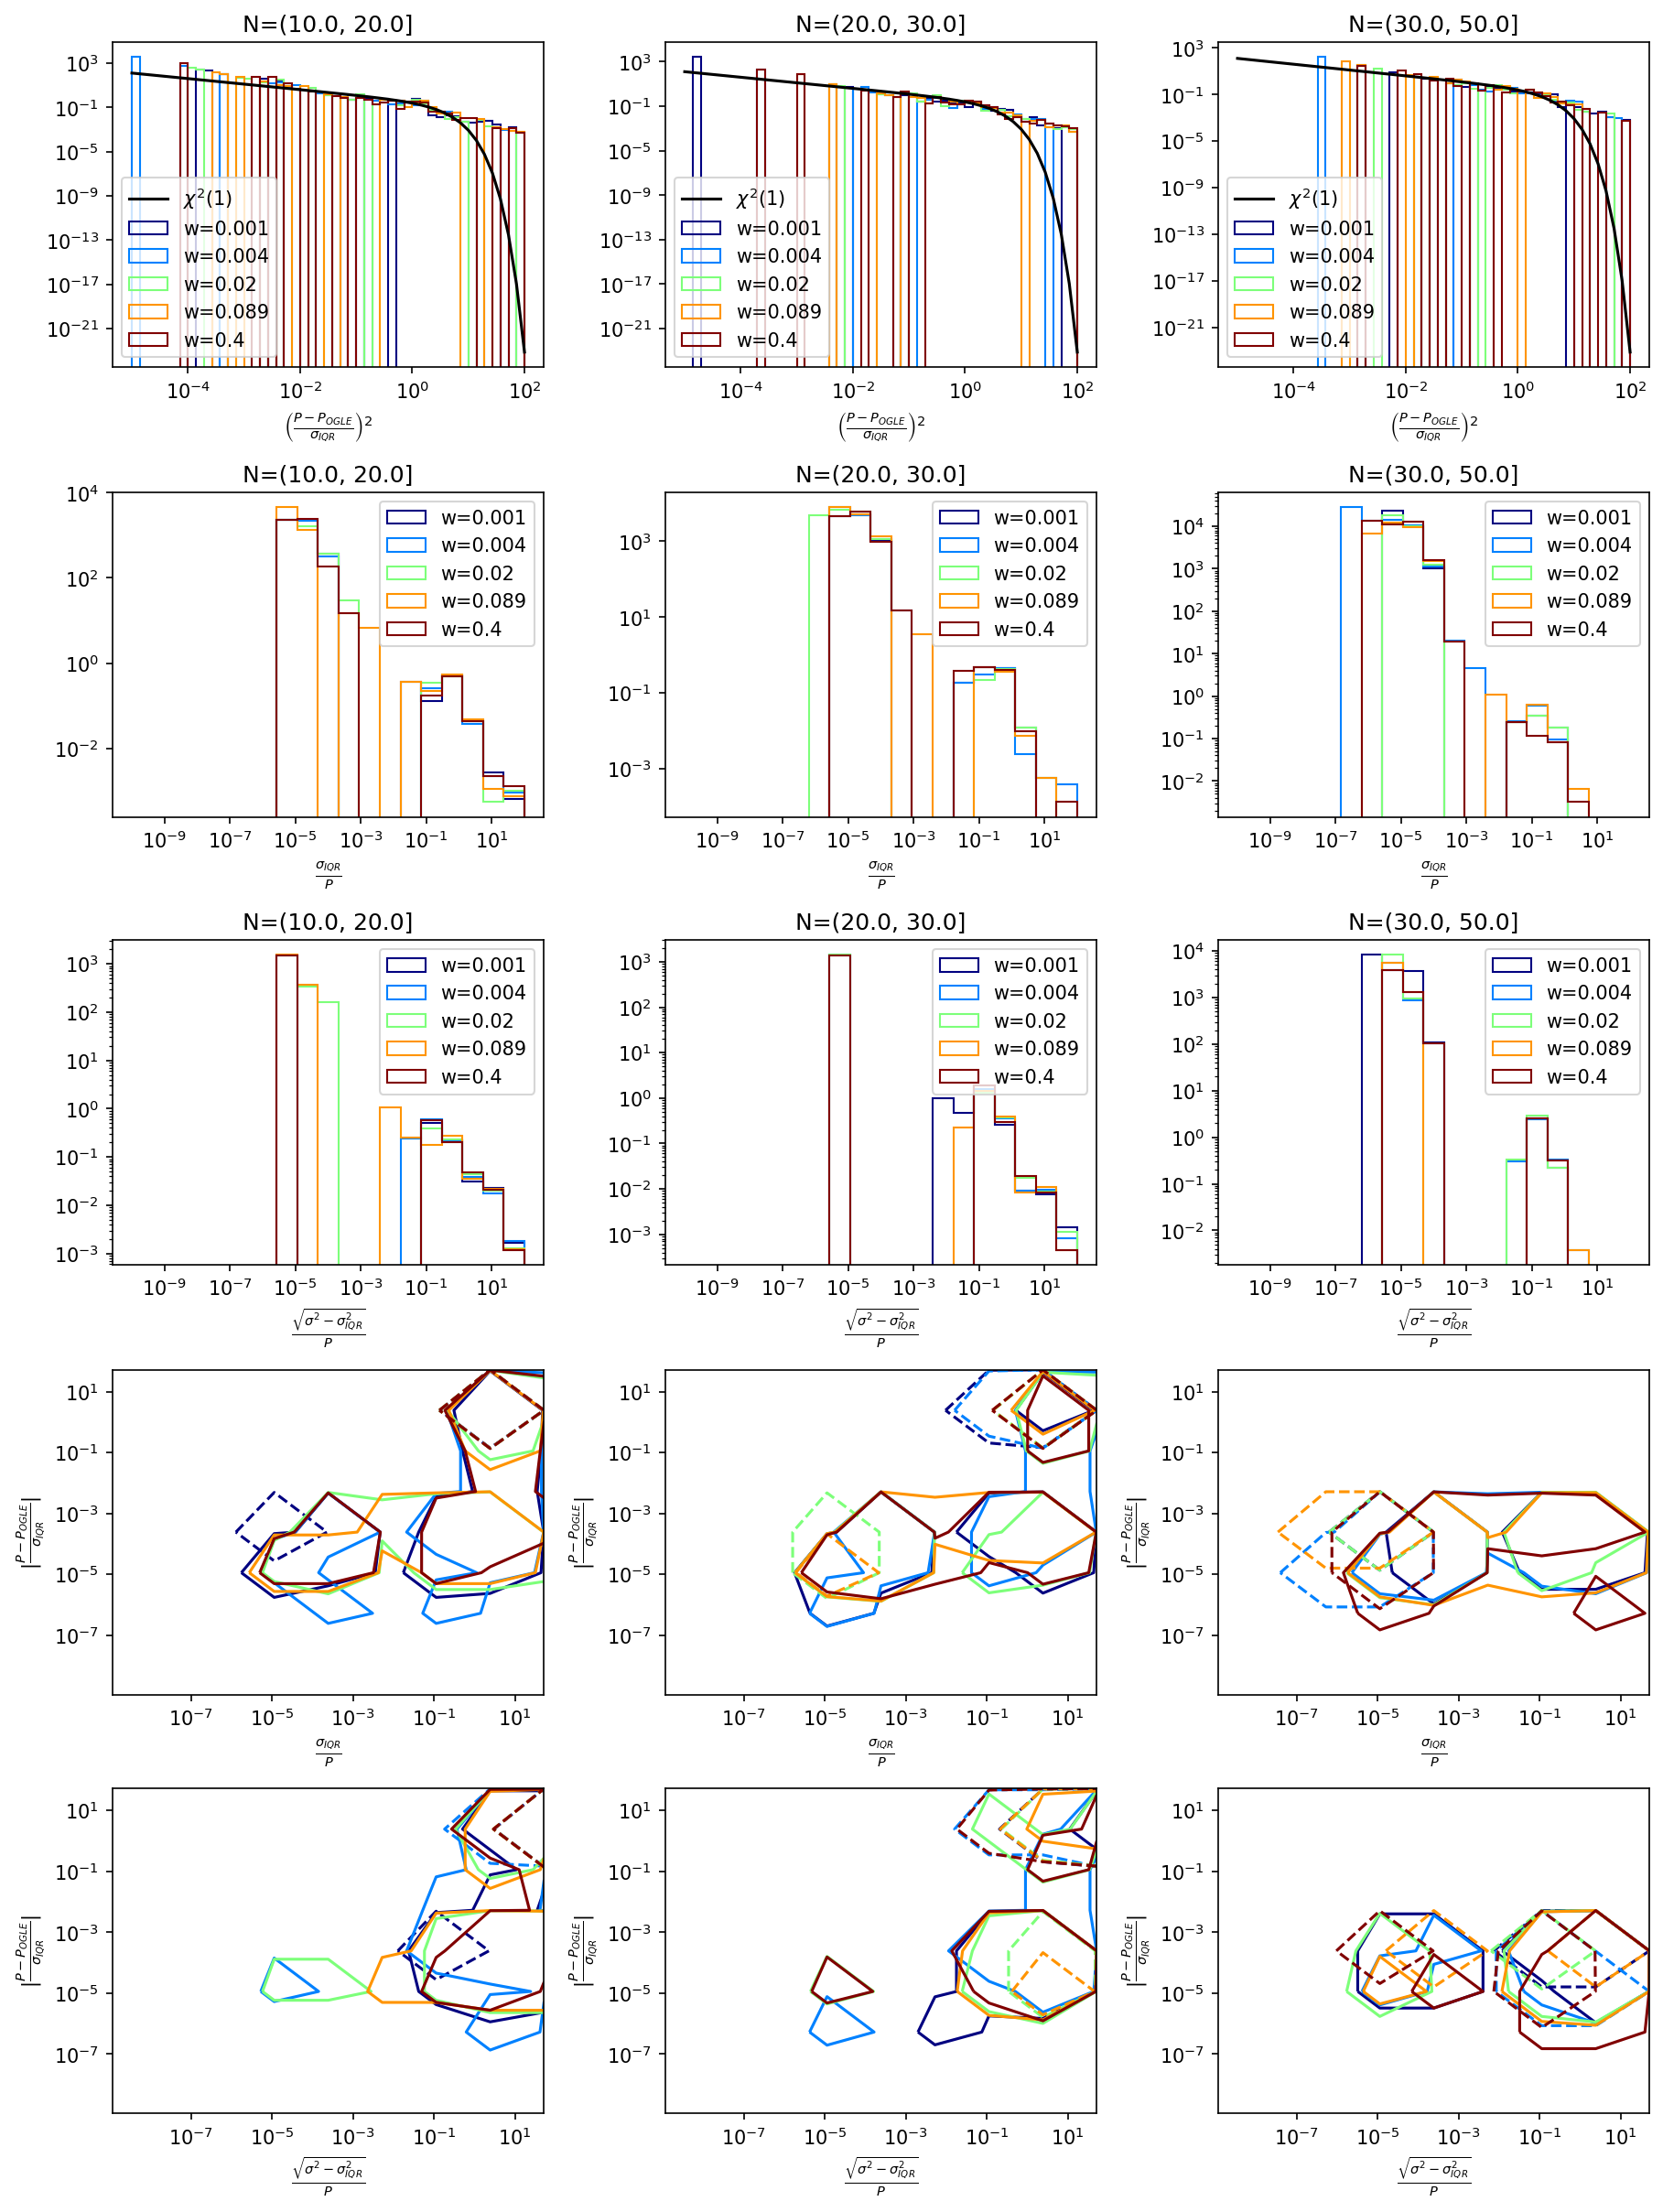

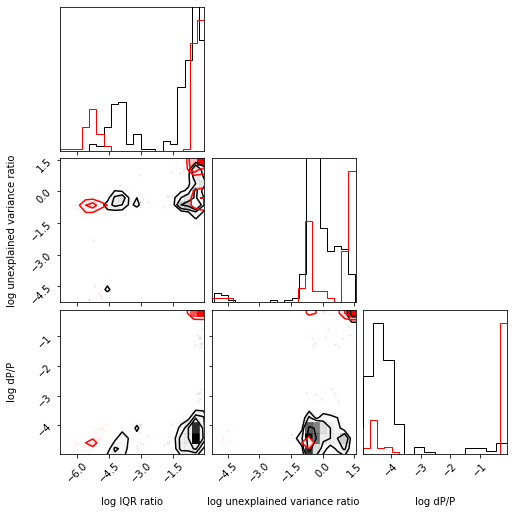

In [244]:
Analysis['IQR Z score'] = (Analysis[f'median']-Analysis['OGLE period'])/Analysis['med_sig']
Analysis['IQR Q'] = Analysis['IQR Z score']**2
Analysis['log IQR Q'] = np.log10(Analysis['IQR Q'])
Analysis['IQR ratio'] = Analysis['med_sig']/Analysis['median']
Analysis['dP/P'] = abs(Analysis[f'median']-Analysis['OGLE period'])/Analysis['OGLE period']
Analysis['log dP/P'] = np.log10(Analysis['dP/P'] )
Analysis['unexplained variance ratio'] = np.sqrt(Analysis[f'unexplained_variance']/Analysis[f'median']**2)
Analysis['log IQR ratio'] =np.log10(Analysis['IQR ratio'] )

Analysis['log unexplained variance ratio'] =np.log10(Analysis['unexplained variance ratio'] )

Nobs = pd.unique(Analysis.Nobs)[:-1]
Wobs = pd.unique(Analysis.window)
colors = plt.cm.jet(np.linspace(0,1,len(Wobs)))
fig, ax = plt.subplots(ncols=Nobs.size, nrows=5, constrained_layout=True,figsize=(4*Nobs.size,4*4),
                             gridspec_kw=dict(width_ratios=Nobs.size*[1], height_ratios=[1,1,1,1,1]),dpi=150)

for a,[_n,g] in zip(ax[0],Analysis.groupby('Nobs')):
    bins = np.logspace(-5,2,50)
    for color,[_w,K] in zip(colors,g.groupby('window')):
        
        a.hist((K['IQR Q']),bins,label=f'w={_w}',histtype='step',color=color,density=True)
    a.plot(bins,sc.chi2(1).pdf(bins),'k',label=r'$\chi^2(1)$')
    
        #a.axvline((K['IQR Z score']).median(),color=color,ls='dashed')
    a.set_yscale('log')
    a.set_xscale('log')
    a.set_title(f'N={_n}')
    a.legend()
    a.set_xlabel(r'$\left(\frac{P-P_{OGLE}}{\sigma_{IQR}}\right)^2$')
for a,[_n,g] in zip(ax[1],Analysis.groupby('Nobs')):
    for color,[_w,K] in zip(colors,g.groupby('window')):
        a.hist((K['IQR ratio']),np.logspace(-10,2,20),label=f'w={_w}',histtype='step',color=color,density=True)
    a.set_yscale('log')
    a.set_xscale('log')
    a.set_title(f'N={_n}')
    a.legend()
    a.set_xlabel(r'$\frac{\sigma_{IQR}}{P}$')
for a,[_n,g] in zip(ax[2],Analysis.groupby('Nobs')):
    for color,[_w,K] in zip(colors,g.groupby('window')):
        a.hist((K['unexplained variance ratio']),np.logspace(-10,2,20),label=f'w={_w}',histtype='step',color=color,density=True)
    a.set_yscale('log')
    a.set_xscale('log')
    a.set_title(f'N={_n}')
    a.legend()
    a.set_xlabel(r'$\frac{\sqrt{\sigma^2-\sigma_{IQR}^2}}{P}$')
for a,[_n,g] in zip(ax[3],Analysis.groupby('Nobs')):
    for color,[_w,Ks] in zip(colors,g.groupby('window')):
        Ks = Ks.dropna()
        K = Ks[Ks['IQR Q']<1]
        counts,ybins,xbins = np.histogram2d(K['IQR ratio'], K['dP/P'],bins=np.logspace(-10,2,10))
        a.contour(*np.meshgrid(0.5*(xbins[:-1]+xbins[1:]), 0.5*(ybins[:-1]+ybins[1:]),indexing='ij'),counts/np.sum(counts),levels=np.logspace(-2,0,2),colors=5*[color])
        K = Ks[Ks['IQR Q']>20]
        counts,ybins,xbins = np.histogram2d(K['IQR ratio'], K['dP/P'],bins=np.logspace(-10,2,10))
        a.contour(*np.meshgrid(0.5*(xbins[:-1]+xbins[1:]), 0.5*(ybins[:-1]+ybins[1:]),indexing='ij'),counts/np.sum(counts),levels=np.logspace(-2,0,2),colors=5*[color],linestyles='dashed')
        a.set_yscale('log')
        a.set_xscale('log')
        a.set_xlabel(r'$\frac{\sigma_{IQR}}{P}$')
        a.set_ylabel(r'$\left|\frac{P-P_{OGLE}}{\sigma_{IQR}}\right|$')
for a,[_n,g] in zip(ax[4],Analysis.groupby('Nobs')):
    for color,[_w,Ks] in zip(colors,g.groupby('window')):
        Ks = Ks.dropna()
        K = Ks[Ks['IQR Q']<1]
        counts,ybins,xbins = np.histogram2d(K['unexplained variance ratio'], K['dP/P'],bins=np.logspace(-10,2,10))
        a.contour(*np.meshgrid(0.5*(xbins[:-1]+xbins[1:]), 0.5*(ybins[:-1]+ybins[1:]),indexing='ij'),counts/np.sum(counts),levels=np.logspace(-2,0,2),colors=5*[color])
        K = Ks[Ks['IQR Q']>20]
        counts,ybins,xbins = np.histogram2d(K['unexplained variance ratio'], K['dP/P'],bins=np.logspace(-10,2,10))
        a.contour(*np.meshgrid(0.5*(xbins[:-1]+xbins[1:]), 0.5*(ybins[:-1]+ybins[1:]),indexing='ij'),counts/np.sum(counts),levels=np.logspace(-2,0,2),colors=5*[color],linestyles='dashed')
        a.set_yscale('log')
        a.set_xscale('log')
        a.set_xlabel(r'$\frac{\sqrt{\sigma^2-\sigma_{IQR}^2}}{P}$')
        a.set_ylabel(r'$\left|\frac{P-P_{OGLE}}{\sigma_{IQR}}\right|$')

from corner import corner
K = Analysis[Analysis['IQR Q']<0.1]
fig=corner(K[['log IQR ratio','log unexplained variance ratio','log dP/P']].dropna());
K = Analysis[Analysis['IQR Q']>10]
corner(K[['log IQR ratio','log unexplained variance ratio','log dP/P']].dropna(),fig=fig,color='r',titles=[r'$\log\frac{\sigma_{IQR}}{P}$',r'$\log\frac{\sqrt{\sigma^2-\sigma_{IQR}^2}}{P}$',r'$\log\left|\frac{P-P_{OGLE}}{\sigma_{IQR}}\right|$']);

In [ ]:
# windowing, podjela po tipu. # jitter